In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import json
from sklearn.preprocessing import StandardScaler

class Data:
    def __init__(self):
        self.data = pd.read_csv('../data/year_data/2018-01-01_2018-08-30.csv')

    # Get the Dataframe
    # returns Dataframe
    def get_data(self):
        return self.data
        
    # Return a Json Dict of building energy consumption totals from Jan 1, Aug 30
    # 'columns' - Building Names
    # 'data' - Building Energy Consumption Totals
    def get_bldg_totals(self):
        bldg_tot = self.data.sum()[1:]
        bldg_tot = bldg_tot.divide(4)
        bldg_tot = pd.DataFrame(bldg_tot).transpose().to_json(orient='split')
        bldg_tot = json.loads(bldg_tot)
        bldg_tot['data'] = bldg_tot['data'][0]
        return bldg_tot

    
    # Get the Starting and Ending Indexes Between Two Months
    # param start (int) - Number representing the Month
    # param end (int) - Number representing the Ending Month
    # Returns (dataframe) - Sliced Dataframe of Selected Data 
    def slice_by_month(self, start, end=None):
        start_idx = self.get_month_start(start)
        end_idx = 0
        if end == None:
            if start == 12: end_idx = len(self.data)
            else: end_idx = self.get_month_start(start + 1)
        else:
            if end == 12: end_idx = len(self.data)
            else: end_idx = self.get_month_start(end + 1)
                
        print(start_idx)
        print(end_idx)
        return self.get_slice(start_idx, end_idx)
    
    # Get the First Index of the Dataframe of the Given Month
    # param month (int) - Number of the Month (eg. Feb = 2)
    # returns index where the month starts in the dataframe
    def get_month_start(self, month):
        for i in range(len(self.data)):
            if(self.data['time'][i].split('/')[0] == str(month) 
              and self.data['time'][i].split('/')[1] == '1'
              and self.data['time'][i].split('/')[2].split()[1] == '0:00'):
                return i
   
    # Get Consumption Data for the Last Number of Days
    # param 'days' - Number of Days to Select
    # Returns Sliced Dataframe
    def get_last(self, days):
        end = len(self.data)
        start = end - 96*days
        return self.get_slice(start, end)
    
    # Get Consumption Data for a Defined Slice
    # param 'start' - Starting Index
    # param 'end' - Ending Index
    # Returns Sliced Dataframe
    def get_slice(self, start, end):
        return self.data.iloc[start:end, :]
    
    # Replace Nan's with 0
    def replace_nan_0(self):
        for i in range(1, self.data.shape[1]):
            self.data.iloc[1:, i] = self.data.iloc[1:, i].fillna(0)


In [54]:
# Importing the libraries
import numpy as np
import pandas as pd
import json
from sklearn.preprocessing import StandardScaler
import pickle

class Classify:
    def __init__(self, data, thresh):
        self.data = data.get_data()
        self.thresh = thresh
        self.classifications = self.gen_classifications()
     
    # Get the Dataframe
    # returns Dataframe
    def get_data(self):
        return self.data
        
    # Get Threshold Level
    # returns Threshold level
    def get_thresh(self):
        return self.thresh
    
    # Get Classification Data
    # returns Classification Data (Dataframe)
    def get_classifications(self):
        return self.classifications  
    
    # Get Classifications for All Buildings at Every Day
    # Param data - Dataframe to classify
    def gen_classifications(self):
        energy_data = self.reshape_data()
        original_len = len(energy_data)
        
        energy_y = []
        for i in range(len(energy_data)): energy_y.append(i)
        energy_y = pd.DataFrame(energy_y)
        
        energy_data, energy_y = self.remove_small(pd.DataFrame(energy_data), energy_y)
        energy_y = energy_y.iloc[:, 0]
        
        sc = StandardScaler()
        energy_data = sc.fit_transform(energy_data)

        # Get List of Buildings
        buildings = list(self.get_data())[1:]

        # Get List of dates
        dates = pd.DataFrame(self.get_data().iloc[:,0])
        dates = self.group_df(df=dates, method="mean", interval='day')
        for i in range(dates.shape[0]): dates.iloc[i, 0] = dates.iloc[i, 0].split()[0]
        dates = list(dates.iloc[:, 0])

        classifications = self.classify(energy_data)

        # Create building_type Array
        building_type = []
        for i in range(original_len): building_type.append(-1)
        for i in range(len(energy_y)): building_type[energy_y[i]] = classifications[i]

        # Create Classification df Date, Building Type
        dates = dates * 134
        updated_bldg = [] 
        for i in buildings: updated_bldg += [i] * 237

        # Create List of Day Types
        day_type = Tools.classify_day_type(dates)

        #Create Building Classification Dataframe
        arrays = [day_type, dates, updated_bldg, building_type]
        labels = ['Day_Type', 'Date', 'Building', 'Type']
        bldg_classes = Tools.arrays_to_df(arrays, labels)
        
        # Remove Weekends and Holidays from the Dataset
        wkday_bldg = bldg_classes[bldg_classes['Day_Type'] > 0].reset_index()
        return self.table_bldg_classes(wkday_bldg)


    # Plot Building Types over Time Given a Dataframe with the Columns: 'Building', 'Data', 'Type'
    # param bldg_df (dataframe): dataframe with the building data
    # return bldg_classes [bldg label (arr), dates (arr), types(arr)]
    def table_bldg_classes(self, bldg_df):
        counter = 0
        # Arrays for Dataframe Creation
        bldgs_labels = []
        dates_arr = []
        types_arr = []
        # Arrays Collect Information for Each Building then Reset for next Building
        prev_bldg = bldg_df['Building'][0]
        dates = []
        bldg_type = []
        for i in range(len(bldg_df)):    
            curr_bldg = bldg_df['Building'][i]
            # Graph Old Building if Current Bldg is New or Last Bldg
            if curr_bldg != prev_bldg or i == len(bldg_df):
                counter += 1
                bldgs_labels.append(prev_bldg)
                dates_arr.append(dates)
                types_arr.append(bldg_type)
                dates = []
                bldg_type = []
                prev_bldg = curr_bldg
            else:
                dates.append(bldg_df['Date'][i])
                bldg_type.append(bldg_df['Type'][i])
        return [bldgs_labels, dates_arr, types_arr]

    # Remove Instances With Energy Usage Below thresh kwH
    def remove_small(self, X, y):
        final_X, final_y = pd.DataFrame(), pd.DataFrame()
        y_list = list(y.iloc[:, 0])
        new_df = []
        new_y = []
        for i in range(0, X.shape[0]):
            if X.iloc[i, :].mean() > self.thresh*4:
                new_df.append(X.iloc[i, :].values)
                new_y.append(y_list[i])
        final_X = pd.concat([final_X, pd.DataFrame(new_df)])
        final_y = pd.concat([final_y, pd.DataFrame(new_y)])
        return final_X, final_y


    # Classify incoming data
    # param (data) - Data to classify
    def classify(self, data):
        filename = 'building_classification_model.p'
        loaded_model = pickle.load(open(filename, 'rb'))
        return loaded_model.predict(data)
    
    # Group By Interval with some Method
    # Methods: Sum, Mean, Min, or Max
    # Returns a df of grouped data
    def group_df(self, df, method="mean", interval='day', has_time_col=True):
        interval = Tools.time_to_row(interval)
        grouped_df = pd.DataFrame()   
        for i in range(0,len(df)//interval):
            if has_time_col: start_date = df['time'][i*interval]
            block = df.iloc[ i*interval:(i+1)*interval, : ]
            # Perform Computation on Row
            if method == "sum": block = block.sum(axis=0)
            elif method == "mean": block = block.mean(axis=0)
            elif method == "min": block = block.min(axis=0)
            elif method == "max": block = block.max(axis=0)
            else:
                print("Invalid Method Entry")
                return
            # Add the Start Date Label
            if has_time_col:
                if method == "mean": block = pd.Series([start_date]).append(block)  
                else: block[0] = start_date
            block = block.to_frame().transpose()
            grouped_df = grouped_df.append(block)
        if method == "mean" and has_time_col: grouped_df = grouped_df.rename(columns={ grouped_df.columns[0]: "time" })
        return grouped_df
        
    # Reshape Training Data
    # Formats it for Classification Model
    def reshape_data(self, has_time_col=True, agg_interval="0:15", time_interval="day"):
        X = self.data
        if has_time_col: X = X.drop(columns=['time'])
        # Determine Shape of New Dataframe and Reshape
        new_col_ct = int(Tools.time_to_row(time_interval)/Tools.time_to_row(agg_interval))
        rows_per_instance = int(X.shape[0]/new_col_ct)
        X = X.T.values.reshape(X.shape[1] * rows_per_instance, new_col_ct)
        return X

In [127]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sc
import matplotlib.pyplot as plt
import copy

class Entropy:
    def __init__(self, classify_obj):
        self.classifications = classify_obj.get_classifications()
        self.entropy = [self.classifications[0], self.entropy_list(self.classifications[2])]
 
    # Get Entropy Scores
    # returns Entropy Scores (Dataframe)
    def get_entropy(self):
        return self.entropy
        
    # Get Classification Data
    # returns Classification Data (Dataframe)
    def get_classifications(self):
        return self.classifications
        
    # data (arr or series) - Pandas series to calculate entropy
    # Uses Boltzmann's Entropy
    def entropy_calc(self, data):
        from sklearn.preprocessing import StandardScaler
        data = pd.Series(data)
        p_data= data.value_counts()/len(data) # calculates the probabilities
        entropy= sc.stats.entropy(p_data)  # input probabilities to get the entropy 
        return entropy
    
    # data  (arr) - Bldg Classification Arrays
    # entropy (arr) - Entropy Scores
    def entropy_list(self, data):
        scores = []
        for bldg_types in data:
            data_series = pd.Series(bldg_types)
            scores.append(self.entropy_calc(data_series))
        return scores
    
    # Graph Entropy Scores
    # param scores (arr) - List of Entropy Scores
    def graph_entr(self):
        plt.figure(figsize=(25,5))
        plt.title('Entropy of Building Classifications')
        plt.xlabel('Bldgs')
        labels = self.entropy[0]
        ticks = [i for i in range(1, len(labels) + 1)]
        plt.xticks(ticks, labels, rotation='vertical')
        plt.ylabel('Entropy')
        plt.plot(self.entropy[1])
        plt.show()
        
    # Heatmap of Entropy Scores
    # param scores (arr) - List of Entropy Scores
    def heatmap_entr(self, scores):
        ax = sns.heatmap(pd.DataFrame(entropy_scores), yticklabels=False, xticklabels=False)
        
    # Sort Building by Entropy
    # param bldgs (arr) - Building Names
    # param entr (arr) - Associated Entropy Scores
    # return bldgs, entr - Sorted Lists
    def entropy_sort(self):
        bldgs, entr = self.entropy[0], self.entropy[1]
        if(len(bldgs) != len(entr)):
            print('Building and Entropy Array Must be The Same Length')
            return
        for passnum in range(len(entr)-1,0,-1):
            for i in range(passnum):
                if entr[i]>entr[i+1]:
                    # Swap Entropy Scores in Array
                    temp_entr = entr[i]
                    entr[i] = entr[i+1]
                    entr[i+1] = temp_entr
                    # Swap Bldg Names in Array
                    temp_bldg = bldgs[i]
                    bldgs[i] = bldgs[i+1]
                    bldgs[i+1] = temp_bldg
        return bldgs, entr
    
    # Calculate Cumulative Entropy of Building Classifications Over Time
    # param bldg_arr (arr): [[bldg_names], [date], [classification]]
    # returns bldg_entr_over_t (arr) Array of Bldg Cumulative Entropy Arrays for each bldg
    def cum_entropy(self, bldg_arr):
        bldg_entr_over_t = []
        for i in range(0, len(bldg_arr[0])):
            entr_over_t = []
            for j in range(1, len(bldg_arr[2][0])):
                entr = entropy_calc(pd.Series(bldg_arr[2][i][:j]))
                entr_over_t.append(entr)
            bldg_entr_over_t.append(entr_over_t)
        return bldg_entr_over_t

    # Calculate Sliding Window Entropy of Building Classifications Over Time
    # param bldg_arr (arr): [[bldg_names], [date], [classification]]
    # param window_size (int): Size of Window
    # returns bldg_entr_over_t (arr) Array of Bldg Cumulative Entropy Arrays for each bldg
    def sliding_entropy(self, bldg_arr, window=14):
        bldg_entr_over_t_slide = []
        for i in range(0, len(wkday_bldg_arr[0])):
            entr_over_t = []
            for j in range(1, len(wkday_bldg_arr[2][0]) - window):
                entr = entropy_calc(pd.Series(wkday_bldg_arr[2][i][j:j + window]))
                entr_over_t.append(entr)
            bldg_entr_over_t_slide.append(entr_over_t)
        return bldg_entr_over_t_slide
    

In [4]:
# Importing the libraries
import numpy as np
import pandas as pd
import json
from sklearn.preprocessing import StandardScaler
from datetime import date

class Tools:
    def __init__(self):
        pass
    
    # Convert a time interval into the correct number of rows
    # Interval: "3:15", "hour", day", "week", "month", "year" 
    def time_to_row(interval):
        time_conv =	{ "year": 35040, "month": 2880, "week": 672, "day": 96, "hour": 4}
        if interval in time_conv: return time_conv[interval]
        elif ":" in interval: return int(interval.split(':')[0])*4 + int(interval.split(':')[1])//15
        else: return

        
    # param arrays (arr) An array of arrays (data for each column)
    # param labels (arr) An array of associated labels (str)
    # return df final dataframe
    def arrays_to_df(arrays, labels):
        if len(arrays) <= 1:
            print("Array must contain more than one array.")
            return
        # Start with First Column
        final_df = pd.DataFrame()
        # Add Remaining Arrays
        for i in range(0, len(arrays)):
            new_col = pd.DataFrame(arrays[i], columns=[labels[i]])
            final_df = pd.concat([final_df, new_col], axis=1)
        return final_df

    # Get List of Day Types. 1-5: M-F, -1: Weekend, -2: Holiday
    # Param dates: List of Dates in 'MM/DD/YYYY' Format
    # Param holidays: List of Holidays in 'MM/DD/YY' Format
    def classify_day_type(dates):
        holidays = ['1/1/2016', '1/2/2016', '1/18/2016', '3/21/2016', '3/22/2016', '3/23/2016',
            '3/24/2016', '3/25/2016','9/5/2016', '10/10/2016', '10/11/2016', '11/23/2016',
            '11/24/2016', '11/25/2016','12/25/2016', '12/26/2016', '12/27/2016',
            '12/28/2016', '12/29/2016', '12/30/2016','12/31/2016', '1/1/2017', '1/2/2017',
            '1/16/2017', '3/19/2017', '3/20/2017','3/21/2017', '3/22/2017', '3/23/2017',
            '3/24/2017', '5/28/2017', '7/3/2017', '7/4/2017', '9/4/2017', '10/9/2017',
            '10/10/2017', '11/22/2017', '11/23/2017', '11/24/2017', '12/25/2017', '12/27/2017',
            '12/28/2017', '12/29/2017', '12/30/2017','12/31/2017', '1/1/2018', '1/2/2018',
           '1/15/2018', '3/19/2018', '3/20/2018', '3/21/2018', '3/22/2018', '3/23/2018',
           '5/28/2018', '7/3/2018', '7/4/2018', '9/3/2018', '10/8/2018', '10/9/2018',
           '11/21/2018', '11/22/2018', '11/23/2018', '12/24/2018', '12/25/2018',
            '12/26/2018', '12/27/2018', '12/28/2018']
        day_type = []
        for i in dates:
            date_elem = i.split('/')
            day_of_week = date(int(date_elem[2]), int(date_elem[0]), int(date_elem[1])).isoweekday()
            if day_of_week > 5: day_type.append(-1)
            elif i in holidays: day_type.append(-2)
            else: day_type.append(day_of_week)
        return day_type

#### Object Testing

In [5]:
bldg_data = Data()
bldg_data.replace_nan_0()

In [56]:
bldg_classify = Classify(bldg_data, 31)

C:\Users\Kunal\Anaconda\envs\py35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [52]:
#bldg_classify.get_classifications()

In [53]:
#bldg_classify.get_data()

In [11]:
bldg_classify.get_thresh()

31

In [15]:
Tools.time_to_row('year')

35040

#### Sandbox

In [55]:
#bldg_data.get_last(12)

In [17]:
bldg_data.get_month_start(6)

14016

In [50]:
#bldg_data.slice_by_month(6)

In [144]:
bldg_classify = Classify(bldg_data, 31)

#### Entropy Workflow

In [128]:
entropy = Entropy(bldg_classify)

In [129]:
entropy.get_entropy()

[['B101',
  'B107',
  'B108',
  'B109',
  'B110',
  'B114',
  'B115',
  'B116',
  'B117',
  'B118',
  'B119',
  'B123',
  'B124',
  'B129',
  'B130',
  'B138',
  'B141',
  'B144',
  'B145',
  'B147',
  'B148',
  'B152',
  'B155',
  'B158',
  'B165',
  'B167',
  'B177',
  'B181',
  'B189',
  'B196',
  'B199',
  'B203',
  'B302',
  'B318',
  'B320',
  'B336',
  'B362',
  'B003',
  'B006',
  'B007',
  'B008',
  'B009',
  'B010',
  'B011',
  'B013',
  'B014',
  'B020',
  'B022',
  'B024',
  'B025',
  'B029',
  'B031',
  'B032',
  'B035',
  'B036',
  'B038',
  'B039',
  'B040',
  'B041',
  'B045',
  'B046',
  'B050',
  'B051',
  'B054',
  'B058',
  'B059',
  'B061',
  'B064',
  'B065',
  'B066',
  'B071',
  'B075',
  'B076',
  'B081',
  'B084',
  'B086',
  'B090',
  'B091',
  'B092',
  'B093',
  'B094',
  'B095',
  'B098',
  'B033B',
  'B051D',
  'B051F',
  'B060A',
  'B061A',
  'B080A',
  'B103',
  'B139',
  'B790',
  'B051W',
  'B085',
  'B104',
  'B015',
  'B051F_C2',
  'B200',
  'B018',

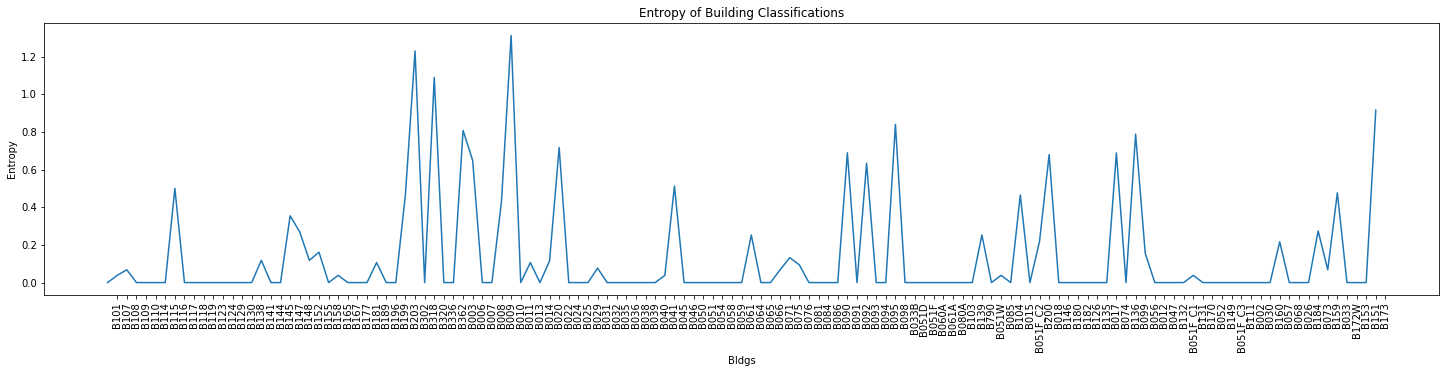

In [131]:
entropy.graph_entr()

In [167]:
entropy.entropy_sort()

(['B101',
  'B109',
  'B110',
  'B114',
  'B115',
  'B117',
  'B118',
  'B119',
  'B123',
  'B124',
  'B129',
  'B130',
  'B138',
  'B144',
  'B145',
  'B158',
  'B167',
  'B177',
  'B181',
  'B196',
  'B199',
  'B318',
  'B336',
  'B362',
  'B007',
  'B008',
  'B011',
  'B014',
  'B024',
  'B025',
  'B029',
  'B032',
  'B035',
  'B036',
  'B038',
  'B039',
  'B040',
  'B046',
  'B050',
  'B051',
  'B054',
  'B058',
  'B059',
  'B061',
  'B065',
  'B066',
  'B081',
  'B084',
  'B086',
  'B090',
  'B092',
  'B094',
  'B095',
  'B033B',
  'B051D',
  'B051F',
  'B060A',
  'B061A',
  'B080A',
  'B103',
  'B139',
  'B051W',
  'B104',
  'B051F_C2',
  'B146',
  'B180',
  'B182',
  'B126',
  'B135',
  'B017',
  'B136',
  'B012',
  'B047',
  'B132',
  'B051F_C1',
  'B170',
  'B052',
  'B149',
  'B051F_C3',
  'B111',
  'B002',
  'B030',
  'B160',
  'B068',
  'B026',
  'B184',
  'B172W',
  'B153',
  'B151',
  'B107',
  'B165',
  'B041',
  'B085',
  'B131',
  'B108',
  'B071',
  'B159',
  'B031',


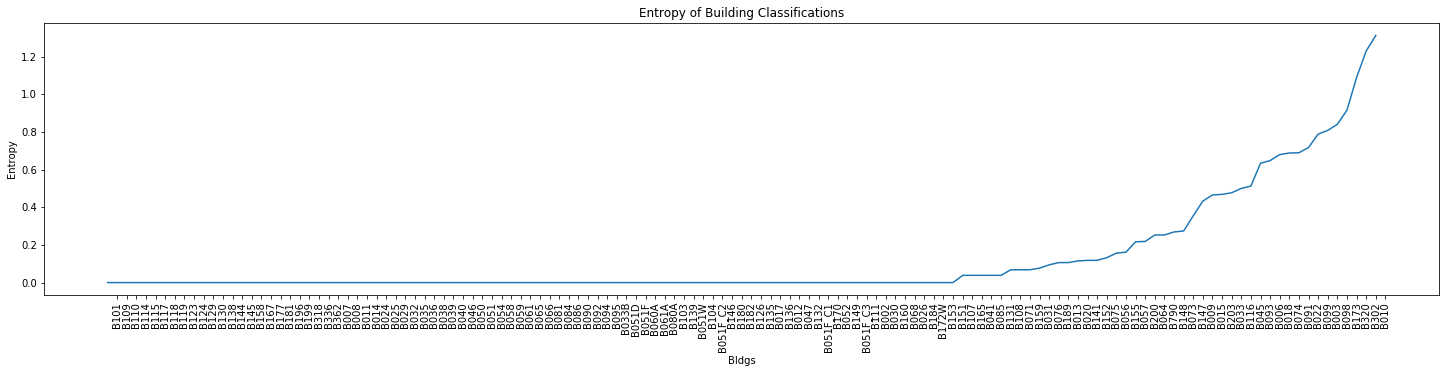

In [133]:
entropy.graph_entr()

In [110]:
#entropy.get_classifications()

In [111]:
#entropy.entropy_calc([3,4,5,6,7,8,9])

In [112]:
entropy_scores = entropy.entropy_list(entropy.get_classifications()[2])

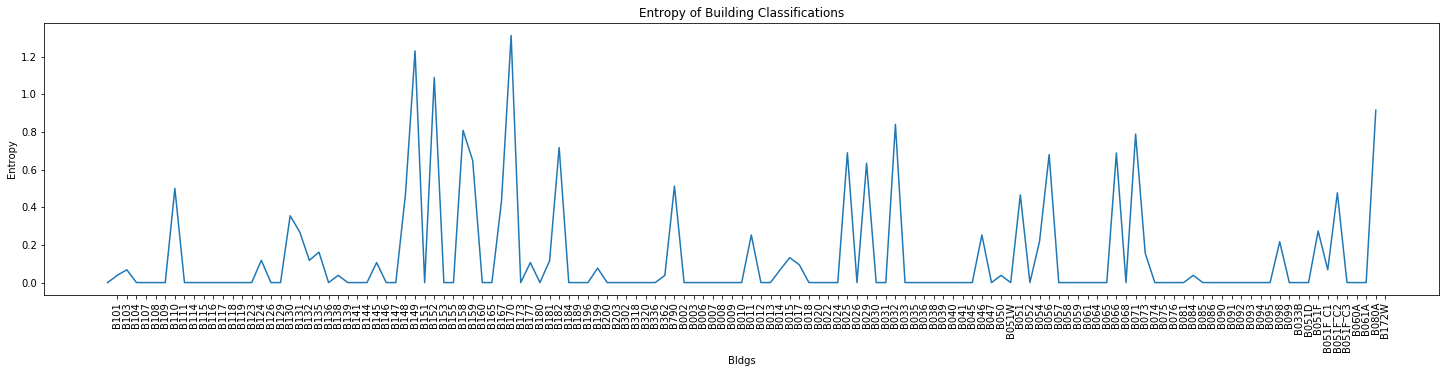

In [113]:
entropy.graph_entropy_scores(entropy_scores)

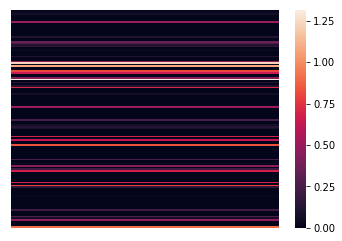

In [34]:
entropy.heatmap_entropy_scores(entropy_scores)

In [75]:
[i for i in range(1, )]

[1, 2, 3, 4]

In [35]:
import copy
bldg_names = copy.deepcopy(entropy.get_classifications()[0])

In [37]:
# Sort Buildings And Associated Entropy
bldgs_sorted, entr_sorted = entropy.entropy_sort(bldg_names, entropy_scores)

In [38]:
for i in range(len(bldgs_sorted)):
    print(bldgs_sorted[i])
    print(entr_sorted[i])

B101
0.0
B107
0.0
B108
0.0
B109
0.0
B110
0.0
B114
0.0
B115
0.0
B116
0.0
B117
0.0
B118
0.0
B119
0.0
B123
0.0
B124
0.0
B129
0.0
B130
0.0
B138
0.0
B141
0.0
B144
0.0
B145
0.0
B147
0.0
B148
0.0
B152
0.0
B155
0.0
B158
0.0
B165
0.0
B167
0.0
B177
0.0
B181
0.0
B189
0.0
B196
0.0
B199
0.0
B203
0.0
B302
0.0
B318
0.0
B320
0.0
B336
0.0
B362
0.0
B003
0.0
B006
0.0
B007
0.0
B008
0.0
B009
0.0
B010
0.0
B011
0.0
B013
0.0
B014
0.0
B020
0.0
B022
0.0
B024
0.0
B025
0.0
B029
0.0
B031
0.0
B032
0.0
B035
0.0
B036
0.0
B038
0.0
B039
0.0
B040
0.0
B041
0.0
B045
0.0
B046
0.0
B050
0.0
B051
0.0
B054
0.0
B058
0.0
B059
0.0
B061
0.0
B064
0.0
B065
0.0
B066
0.0
B071
0.0
B075
0.0
B076
0.0
B081
0.0
B084
0.0
B086
0.0
B090
0.0
B091
0.0
B092
0.0
B093
0.0
B094
0.0
B095
0.0
B098
0.0
B033B
0.0
B051D
0.0
B051F
0.0
B060A
0.0
B061A
0.0
B080A
0.0
B103
0.03835078340871136
B139
0.03835078340871136
B790
0.03835078340871136
B051W
0.03835078340871136
B085
0.03835078340871136
B104
0.0678872387735005
B015
0.0678872387735005
B051F_C2
0.06788723

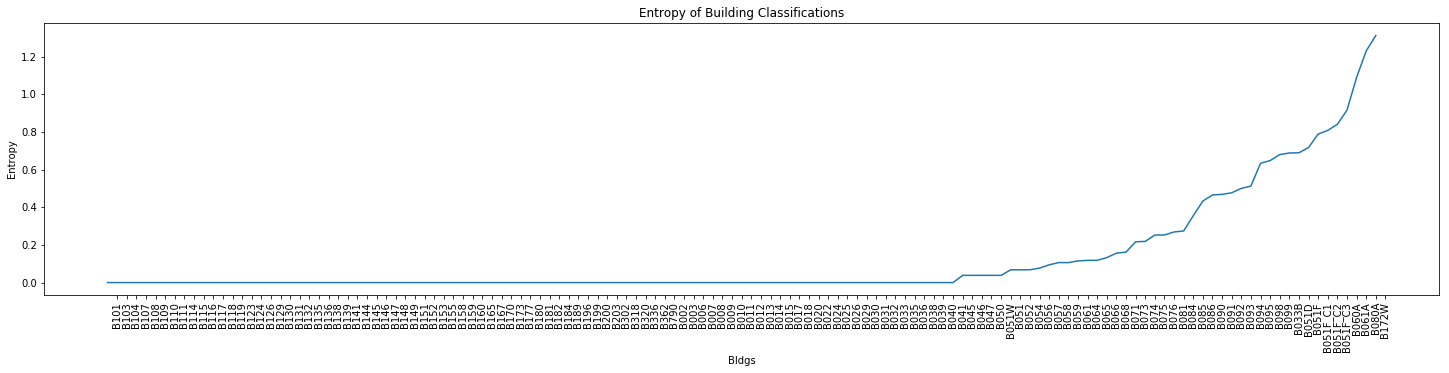

In [114]:
entropy.graph_entropy_scores(entr_sorted)

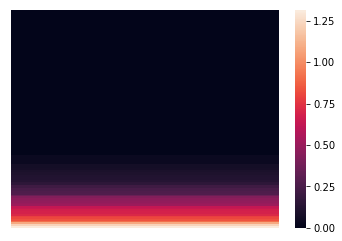

In [49]:
entropy.heatmap_entropy_scores(entr_sorted)